# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
import numpy as np
import scipy.ndimage

In [30]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import matplotlib.image as mpimg

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [4]:
n_train = X_train.shape[0]

n_test = X_test.shape[0]

image_shape = X_test.shape[1:3]

n_classes = len(set(y_train))

with open('signnames.csv') as csvfile:
    class_names = dict(line.rstrip().split(',', 1) for line in csvfile)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


Let's see what's going on with class distributions.

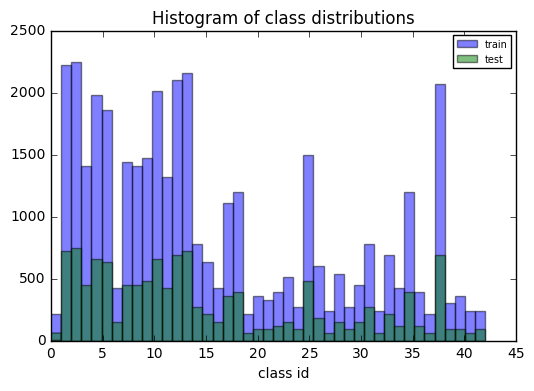

In [5]:
plt.hist(y_train, alpha=0.5, bins=n_classes, label='train')
plt.hist(y_test, alpha=0.5, bins=n_classes, label='test')

plt.title('Histogram of class distributions')
plt.xlabel('class id')
plt.legend(loc='upper right', fontsize=7)

plt.show()

So we see two things here - one good and one bad:

Good: train and test class distribution are roughly the same.

Bad: distribution between classes is far from uniform. We have big guys, e.g. classes 1 and 2, and small classes, e.g. class 0.

---

Let's visualize a couple of examples from some classes class.

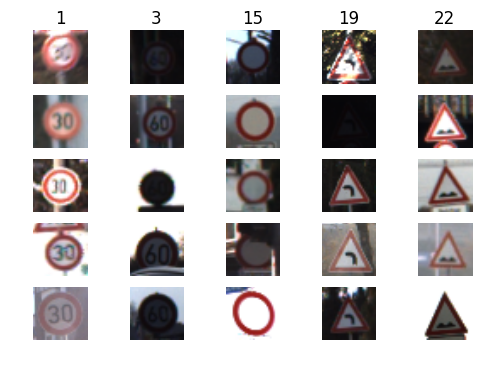

1: Speed limit (30km/h)
3: Speed limit (60km/h)
15: No vehicles
19: Dangerous curve to the left
22: Bumpy road


In [6]:
how_many_classes = 5
samples_per_class = 5

classes = sorted(np.random.choice(np.arange(n_classes), how_many_classes, replace=False))

for y, cls in enumerate(classes):
    idxs = [i for i, label in enumerate(y_train) if label == cls]
    idxs = np.random.choice(idxs, samples_per_class, replace=False)

    for i, idx in enumerate(idxs):
        plt_idx = i * how_many_classes + y + 1
        plt.subplot(samples_per_class, how_many_classes, plt_idx)
        plt.imshow(X_train[idx])
        plt.axis('off')
        
        if i == 0:
            plt.title(cls)

plt.show()

for c in classes:
    print('%d: %s' % (c, class_names[str(c)]))

Looking at the pictures we notice that some images are really dark.
Looks like a future problem.

Also we can see that images are centered and some signs are a little rotated.

We can also note that the training dataset seems to be ordered by class. A good idea would be to shuffle it.

---

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [7]:
import cv2

In [8]:
# some simple data preprocessing

X_train = np.array([cv2.cvtColor(x, cv2.COLOR_RGB2GRAY) for x in X_train])
X_test = np.array([cv2.cvtColor(x, cv2.COLOR_RGB2GRAY) for x in X_test])

X_train = np.array([cv2.equalizeHist(x) for x in X_train])
X_test = np.array([cv2.equalizeHist(x) for x in X_test])

X_train.resize([X_train.shape[0], X_train.shape[1], X_train.shape[2], 1])
X_test.resize([X_test.shape[0], X_test.shape[1], X_test.shape[2], 1])

### Train/Validation split

As we can read online the dataset is organized as follows - for the same physical sign we have 30 different pictures of it in out dataset. That means that simple random split into train / validation sets will produce very simmilar datasets, and basically make out validation sets meaningless. All pictures of one physical sign should be either in train or in validation set.

One small detail: we see that n_train = 39209 is not divisible by 30.
With some exploration we can find that sign which starts at index 33660 occurs 29 times.

In [9]:
from itertools import chain

In [10]:
# Let's remove edge case
idxs = (np.arange(n_train) < 33660) | (np.arange(n_train) >= (33660 + 29))
X_train = X_train[idxs]
y_train = y_train[idxs]

In [11]:
X_train = X_train.astype(np.float64)
y_train = y_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_test = y_test.astype(np.float64)

n_train = X_train.shape[0]
assert n_train % 30 == 0

n_train_corrected = n_train // 30
shuff_idx = np.random.permutation(n_train_corrected)

num_training = int(n_train_corrected * 0.9)
train_idx = shuff_idx[:num_training]
valid_idx = shuff_idx[num_training:]

train_idx = list(chain(*(range(i * 30, (i + 1) * 30) for i in train_idx)))
valid_idx = list(chain(*(range(i * 30, (i + 1) * 30) for i in valid_idx)))

X_val = X_train[valid_idx]
y_val = y_train[valid_idx]
X_train = X_train[train_idx]
y_train = y_train[train_idx]  

In [12]:
# shuffle everything one more time

n_train = X_train.shape[0]
n_valid = X_val.shape[0]

shuff_idx = np.random.permutation(n_train)
X_train = X_train[shuff_idx]
y_train = y_train[shuff_idx]

shuff_idx = np.random.permutation(n_valid)
X_val = X_val[shuff_idx]
y_val = y_val[shuff_idx]

In [13]:
# normalize the data: subtract the mean image
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

### The Model

In [14]:
import tensorflow as tf

from random import randint
from itertools import cycle

In [15]:
tf.reset_default_graph()

In [16]:
def conv_layer(layer_num,
               _input,              
               num_input_channels,
               filter_size,
               num_filters):

    shape = [filter_size, filter_size, num_input_channels, num_filters]

    weights = tf.get_variable("W%d" % layer_num, 
                              shape=shape,
                              initializer=tf.contrib.layers.xavier_initializer())

    biases = tf.Variable(tf.zeros(num_filters))

    layer = tf.nn.conv2d(input=_input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    layer += biases

    layer = tf.nn.max_pool(value=layer,
                           ksize=[1, 2, 2, 1],
                           strides=[1, 2, 2, 1],
                           padding='VALID')

    layer = tf.nn.elu(layer)

    return layer, weights


def fc_layer(layer_num,
             _input,              
             hidden_size,
             add_nonlinearity=True):
    
    shape = [_input.get_shape().as_list()[-1], hidden_size]

    weights = tf.get_variable("W%d" % layer_num, 
                              shape=shape,
                              initializer=tf.contrib.layers.xavier_initializer())

    biases = tf.Variable(tf.zeros(hidden_size))

    layer = tf.matmul(_input, weights) + biases

    if add_nonlinearity:
        layer = tf.nn.elu(layer)

    return layer, weights

In [17]:
# Architecture

# Convolutional Layer 1
filter_size_1 = 3
num_filters_1 = 55

# Convolutional Layer 2
filter_size_2 = 3
num_filters_2 = 66

# Convolutional Layer 3
filter_size_3 = 3
num_filters_3 = 77


# Fully-connected Layer 1
hidden_size_1 = 200

# Fully-connected Layer 2
hidden_size_2 = 150

# Config

reg = 0.001

mini_batch_size = 128

learning_rate = 1e-4

save_file = 'model.ckpt'

In [18]:
features = tf.placeholder(tf.float32, shape=(None,) + X_train.shape[1:])
labels = tf.placeholder(tf.int64)

keep_prob1 = tf.placeholder(tf.float32)
keep_prob2 = tf.placeholder(tf.float32)

oh_labels = tf.one_hot(labels, n_classes)

conv_layer_1, W1 = conv_layer(1, features, 1, filter_size_1, num_filters_1)
conv_layer_2, W2 = conv_layer(2, conv_layer_1, num_filters_1, filter_size_2, num_filters_2)
conv_layer_3, W3 = conv_layer(3, conv_layer_2, num_filters_2, filter_size_3, num_filters_3)
conv_layer_o = tf.contrib.layers.flatten(conv_layer_3)
full_connected_1, W4 = fc_layer(4, conv_layer_o, hidden_size_1)
full_connected_1 = tf.nn.dropout(full_connected_1, keep_prob1)
full_connected_2, W5 = fc_layer(5, full_connected_1, hidden_size_2)
full_connected_2 = tf.nn.dropout(full_connected_2, keep_prob2)
full_connected_3, W6 = fc_layer(6, full_connected_2, n_classes, add_nonlinearity=False)

saver = tf.train.Saver()

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=full_connected_3,
                                                        labels=oh_labels)

cost = tf.reduce_mean(cross_entropy) + reg * tf.nn.l2_loss(W1) + reg * tf.nn.l2_loss(W2) + reg * tf.nn.l2_loss(W3) + reg * tf.nn.l2_loss(W4) + reg * tf.nn.l2_loss(W5) + reg * tf.nn.l2_loss(W6) 


optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

y_pred = tf.nn.softmax(full_connected_3)
y_pred_cls = tf.argmax(y_pred, dimension=1)
correct_prediction = tf.equal(y_pred_cls, labels)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [19]:
costs = []
accs = []
accs_val = []
accs_test = []

feed_dict_val = {
                  features:  X_val,
                  labels:    y_val,
                  keep_prob1: 1,
                  keep_prob2: 1
                }

current_best_acc = 0

def augment(image):
    for _ in range(1):
        angle = randint(-10, 10)
        yield scipy.ndimage.rotate(image, angle, reshape=False)


with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    id_iter = cycle(range(n_train))
    
    for i in range(15000):
        batch_idx = [next(id_iter) for _ in range(mini_batch_size)]
        X_batch = X_train[batch_idx]
        y_batch = y_train[batch_idx]
        
        # data augmentation
        
        xs, ys = [], []
            
        for img, cls in zip(X_batch, y_batch):
            for aug_img in augment(img):
                xs.append(aug_img)
                ys.append(cls)
    
        X_batch = np.vstack((X_batch, xs))
        y_batch = np.hstack((y_batch, ys))
                         
        
        feed_dict_train = {
                            features:  X_batch,
                            labels:    y_batch,
                            keep_prob1: 0.5,
                            keep_prob2: 0.5,
                          }

        sess.run(optimizer, feed_dict=feed_dict_train)
        
        current_cost = sess.run(cost, feed_dict=feed_dict_train)
        costs.append(current_cost)        
        
        if i % 50 == 0:
            # Calculate the accuracy on the training-set.
            feed_dict_train[keep_prob1] = 1.
            feed_dict_train[keep_prob2] = 1.
            acc = sess.run(accuracy, feed_dict=feed_dict_train)
            accs.append(acc)
            acc_val = sess.run(accuracy, feed_dict=feed_dict_val)
            accs_val.append(acc_val)
                        
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}"
            print(msg.format(i + 1, acc, acc_val))
            
            if acc_val > current_best_acc:
                print("Saving ...")
                current_best_acc = acc_val
                saver.save(sess, save_file)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Optimization Iteration:      1, Training Accuracy:   2.3%, Validation Accuracy:   1.1%
Saving ...
Optimization Iteration:     51, Training Accuracy:   5.1%, Validation Accuracy:   7.4%
Saving ...
Optimization Iteration:    101, Training Accuracy:  14.8%, Validation Accuracy:  13.9%
Saving ...
Optimization Iteration:    151, Training Accuracy:  13.3%, Validation Accuracy:  15.5%
Saving ...
Optimization Iteration:    201, Training Accuracy:  21.5%, Validation Accuracy:  18.5%
Saving ...
Optimization Iteration:    251, Training Accuracy:  22.7%, Validation Accuracy:  21.4%
Saving ...
Optimization Iteration:    301, Training Accuracy:  23.8%, Validation Accuracy:  26.1%
Saving ...
Optimization Iteration:    351, Training Accuracy:  28.5%, Validation Accuracy:  29.4%
Saving ...
Optimization Iteration:    401, Training Accuracy:  39.8%, Validation Accuracy:  33.2%
Saving ...
Optimization Iteration:    451, Training Acc

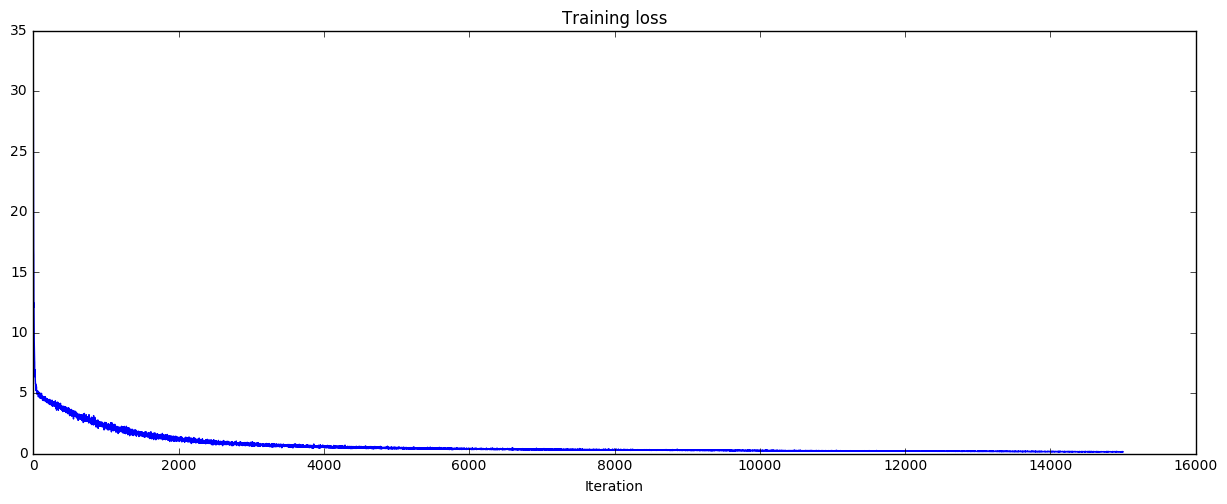

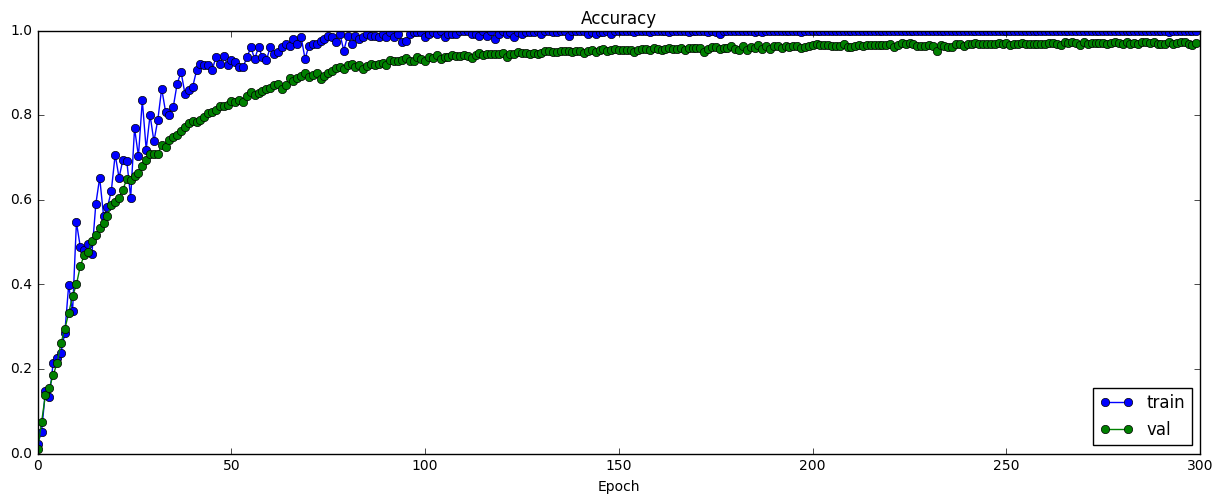

In [20]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(costs)
plt.xlabel('Iteration')
plt.gcf().set_size_inches(15, 12)
plt.show()

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(accs, '-o', label='train')
plt.plot(accs_val, '-o', label='val')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

In [21]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph(save_file + '.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    num_iter = n_test // mini_batch_size + 1
    id_iter = iter(range(n_test))
    
    final_predictions = []
    
    for i in range(num_iter):
        batch_idx = [next(id_iter) for _ in range(mini_batch_size if i != (num_iter - 1) else n_test % mini_batch_size)]

        X_batch = X_test[batch_idx]
        y_batch = y_test[batch_idx]
   
        feed_dict_test = {
                           features:  X_batch,
                           labels:    y_batch,
                           keep_prob1: 1,
                           keep_prob2: 1
                         }    
    
        
        cp = sess.run(correct_prediction, feed_dict=feed_dict_test)
        final_predictions = np.hstack((final_predictions, cp))
        
    assert len(final_predictions) == n_test
    print("Final result on test: %s" % (sum(final_predictions) / len(final_predictions)))

Final result on test: 0.959303246239


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I used basic computer vision preprocessing:
- grayscale all images
- histogram equalization

Also I zero-centered my data by substracting the mean image (computed on train data) from all images.

Motivation:

I chose grayscaling because surprisingly my model worked better on gray images. This is something counter-intuitive, because signs have a lot of color information in them, and throwing it away looks like a huge loss of information. But maybe the "picture" of the sign provides enough hints for the neural networks to guess it correctly, so the color is redundant.

Histogram equalization was a technique I read on the internet when I stuck on 93-94% test accuracy. I was searching for some preprocessing strategy that could make my data more homogeneous. From my experiments it looks like it helps reduce overfitting a little bit, by making data more "equal".

Mean substraction is a standard technique which I use on all machine learning problems.

I did not use another common technique: scale normalization (division by standard deviation), because I don't find it necessary for images, since (citing cs231n) relative scales of pixels are already approximately equal (and in range from 0 to 255).

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

Now this one is really important.

As we can read online the dataset is organized as follows - for the same physical sign we have 30 different pictures of it in out dataset. That means that simple random split into train / validation sets will produce very simmilar datasets, and basically make out validation sets meaningless. All pictures of one physical sign should be either in train or in validation set.

I augmented my images by simple random rotations. This got me +1% test accuracy.

In my final solution I completely ignored the class imbalance problem. Playing with the model architecture turned out to be far more profitable than data balancing.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My final architecture is a pumped up LeNet model.

- Conv 3x3x55 - MaxPool 2x2 - ELU nonlinearity
- Conv 3x3x66 - MaxPool 2x2 - ELU nonlinearity
- Conv 3x3x77 - MaxPool 2x2 - ELU nonlinearity
- Fully-connected 200 - ELU nonlinearity - dropout
- Fully-connected 150 - ELU nonlinearity - dropout
- Fully-connected 43
- Softmax

All weights were L2 regularized.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I used the Adam Optimizer.

My hyperparameters:
 - Droupout prob - 0.5
 - Learning rate - 1e-4
 - Regularization strength - 0.001
 - Mini batch size - 128

Note that every image in the mini batch is on-the-fly augmented with a random rotation - so effectively the mini-batch size was 256.

I train for 15k iterations. I don't have a notion of an epoch, I just cycle through data with minibatches - but 15k iterations is something like 50 epochs.

Also to improve convergence I used Glorot weight initialization.

The final model was chosen based on the best validation accuracy.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I used LeNet as a starting point.

First I tried to train everything on CPU with 2-3 layer models. But that got me to somewhere near 80% test accuracy.

Then, armed with an aws gpu, I experimented a lot with deeper and wider models - basically just stacking more layers and playing with their sizes.

Regularization techniques helped a lot - both dropout and L2. Though I spent quite some time tuning L2 regularization stregnth.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [29]:
import os

In [40]:
X_moscow = np.array([mpimg.imread('my_signs/' + file) for file in sorted(os.listdir('my_signs')) if file.endswith('.jpeg')])

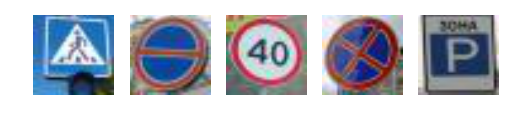

In [41]:
for i, image in enumerate(X_moscow):
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
        
plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

I took random images of signs from google query - "traffic signs moscow" (in Russian).
They don't seem to complicated.

Image 1 has a different object at the bottom.
Image 2 is heavily rotated (it was taken just below the sign)
Images 3 and 4 look easy.
Image 5 has some Russian text on it.

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

In [42]:
# my preprocessing pipeline

X_moscow = np.array([cv2.cvtColor(x, cv2.COLOR_RGB2GRAY) for x in X_moscow])
X_moscow = np.array([cv2.equalizeHist(x) for x in X_moscow])
X_moscow.resize([X_moscow.shape[0], X_moscow.shape[1], X_moscow.shape[2], 1])
X_moscow = X_moscow.astype(np.float64)
X_moscow -= mean_image

In [48]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph(save_file + '.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    feed_dict_moscow = {
                         features:   X_moscow,
                         keep_prob1: 1,
                         keep_prob2: 1
                       }    
    
        
    predicted = sess.run(y_pred_cls, feed_dict=feed_dict_moscow)

for i, c in enumerate(predicted, 1):
    print('Image%d looks like %s (class %d)' % (i, class_names[str(c)], c))

Image1 looks like Beware of ice/snow (class 30)
Image2 looks like No entry (class 17)
Image3 looks like Speed limit (60km/h) (class 3)
Image4 looks like No entry (class 17)
Image5 looks like Vehicles over 3.5 metric tons prohibited (class 16)


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

Ok, so let's analyze our results.

Image1 - the  model is WRONG.

Let's look at some "Beware of ice/snow" images

In [50]:
# let's load out data again in pure form

X_train_debug, y_train_debug = train['features'], train['labels']

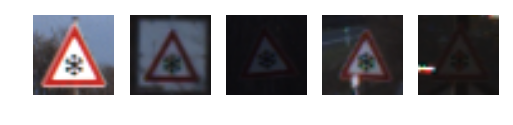

In [51]:
idxs = [i for i, label in enumerate(y_train_debug) if label == 30]
idxs = np.random.choice(idxs, samples_per_class, replace=False)

for i, im_id in enumerate(idxs):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train_debug[im_id])
    plt.axis('off')
        
plt.show()

Great, looks nowhere near our pedestrain =)

Let's look at the German version of the pedestain sign.

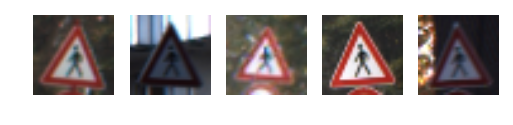

In [53]:
idxs = [i for i, label in enumerate(y_train_debug) if label == 27]
idxs = np.random.choice(idxs, samples_per_class, replace=False)

for i, im_id in enumerate(idxs):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train_debug[im_id])
    plt.axis('off')
        
plt.show()

We can see that the sign is a little different from my Russian version.

Ok, now lets look at Image2 and Image4.
My model says it's "No entry". Let's examine this class:

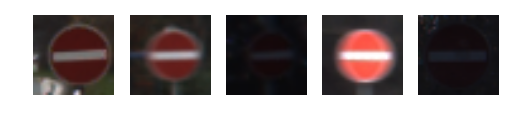

In [60]:
idxs = [i for i, label in enumerate(y_train_debug) if label == 17]
idxs = np.random.choice(idxs, samples_per_class, replace=False)

for i, im_id in enumerate(idxs):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train_debug[im_id])
    plt.axis('off')
        
plt.show()

These two signs in Moscow mean some variations of "no parking". 
As far as I have looked there is no such category in the dataset (but maybe I just missed it).
Formally my model is wrong, but interestingly it got the "restrictive" nature of these signs.

Now let's look at Image3.
Here it's obvious - it got that it is a speed limit, but it got the number wrong.
But 40 was not seen in the dataset, so mistake was unavoidable here.

In [66]:
print('\n'.join(sorted([v for v in class_names.values() if 'Speed limit' in v])))

Speed limit (100km/h)
Speed limit (120km/h)
Speed limit (20km/h)
Speed limit (30km/h)
Speed limit (50km/h)
Speed limit (60km/h)
Speed limit (70km/h)
Speed limit (80km/h)


The last image, which in Moscow means "Parking", is said  to be "Vehicles over 3.5 metric tons prohibited"

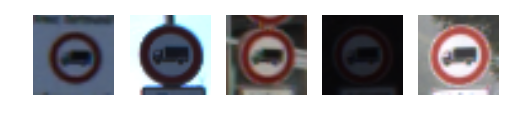

In [67]:
idxs = [i for i, label in enumerate(y_train_debug) if label == 16]
idxs = np.random.choice(idxs, samples_per_class, replace=False)

for i, im_id in enumerate(idxs):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train_debug[im_id])
    plt.axis('off')
        
plt.show()

This one is hard to interpret. The truck just doesn't look like a 'P' =)

In summary I would say:
 - we got 0 images correct =)
 - Image2, Image3, Image4 are good understandable mistakes
 - Image1, Image5 are total random
 
Formally my model achieved 0% generalization accuracy. 

If we are in a good mood we can count Image2, Image3, Image4 as correct predictions, so my generalization accuracy increases to 60%. Anyway, this is far below from our 95.6% test accuracy.

So what does this teach us?

First: we can't expect a system trained in one country to operate "out of the box" in another country. At least some fine-tuning is required.

Second: as we can note with the pedestian sign, it looks like a good idea to collect signs with the same meaning from different countries. This would give us a more robust model that could potentially learn more abstract concepts.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

In [68]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph(save_file + '.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    feed_dict_moscow = {
                         features:   X_moscow,
                         keep_prob1: 1,
                         keep_prob2: 1
                       }    
    
        
    top5 = sess.run(tf.nn.top_k(y_pred, k=5), feed_dict=feed_dict_moscow)

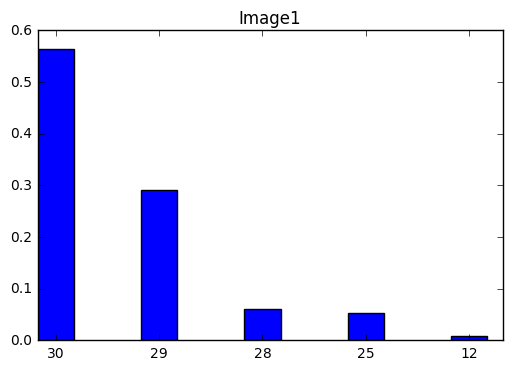

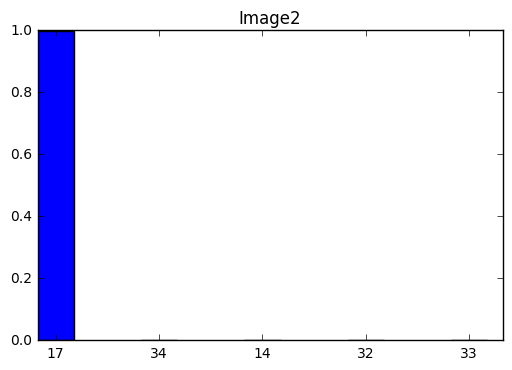

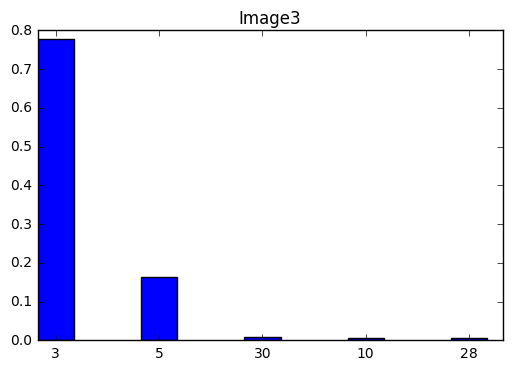

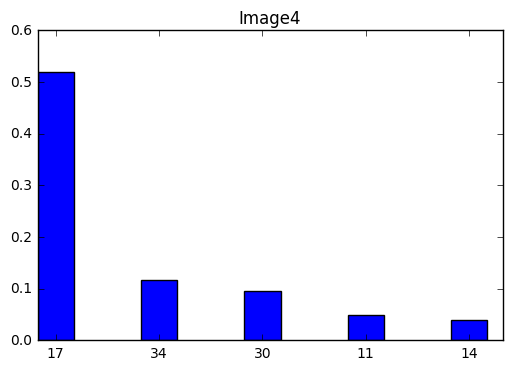

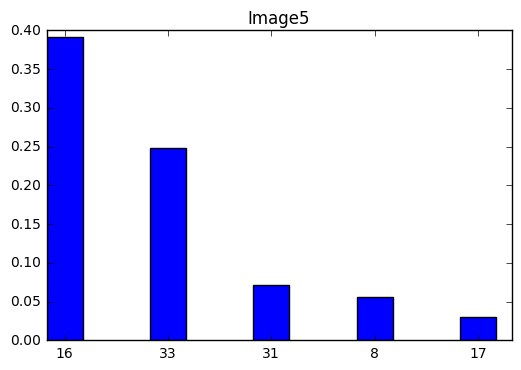

In [91]:
bar_width = 0.35

for i, (values, indices) in enumerate(zip(top5.values, top5.indices), 1):
    index = np.arange(5)
    plt.bar(index, values, bar_width)
    plt.xticks(index + bar_width / 2, indices)
    plt.title("Image%d" % i)
    plt.show()

It's interesting that the model is certain on images 2, 3, 4 (which were all good guesses) and uncertain on images 1 and 5 (where the model outputed some random result).

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.